In [141]:
import math 
import matplotlib.pyplot as plt 
import matplotlib
import nltk
from nltk.corpus import stopwords
import string

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import scikitplot as skplt

import seaborn as sns
import pandas as pd
df1 = pd.read_csv('Fianl_data.csv')
# reading data
import numpy as np


Data Text Preprocessing

In [142]:
df1.head()


,id,review_body,sentiment
0,0,absolutely love watch get compliments almost e...,Positive
1,1,love watch keeps time wonderfully.,Positive
2,2,scratches,Neural
3,3,"works well me. however, found cheaper prices p...",Positive
4,4,beautiful watch face. band looks nice around. ...,Positive


In [143]:

df = df1.dropna()#Taking a 30% representative sample
np.random.seed(34)
df = df1.sample(frac = 0.05)
df.head()

,id,review_body,sentiment
609295,609295,great watch great price. grandson loved great ...,Positive
584695,584695,got watch black friday 50% watch beautiful. ru...,Positive
172002,172002,"nice decent watch, looks pretty good. details ...",Positive
95962,95962,watch looks classy blue dial much brighter per...,Positive
614101,614101,"seriously $2,500 casio watch idea vendor think...",Negative


In [60]:
f=df.shape
print(f)

(48002, 3)


In [144]:
# Lower Case all the reviews
df['review_body']=df['review_body'].str.lower()
df.head()

,id,review_body,sentiment
609295,609295,great watch great price. grandson loved great ...,Positive
584695,584695,got watch black friday 50% watch beautiful. ru...,Positive
172002,172002,"nice decent watch, looks pretty good. details ...",Positive
95962,95962,watch looks classy blue dial much brighter per...,Positive
614101,614101,"seriously $2,500 casio watch idea vendor think...",Negative


In [145]:
# Remove Punctuation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["review_body"] = df["review_body"].astype(str).apply(lambda text: remove_punctuation(text))
df.head()

,id,review_body,sentiment
609295,609295,great watch great price grandson loved great c...,Positive
584695,584695,got watch black friday 50 watch beautiful rubb...,Positive
172002,172002,nice decent watch looks pretty good details li...,Positive
95962,95962,watch looks classy blue dial much brighter per...,Positive
614101,614101,seriously 2500 casio watch idea vendor thinkin...,Negative


In [146]:
# Remove Stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(review_body):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(review_body).split() if word not in STOPWORDS])

df["review_body"] = df["review_body"].apply(lambda review_body: remove_stopwords(review_body))
df.head()

,id,review_body,sentiment
609295,609295,great watch great price grandson loved great c...,Positive
584695,584695,got watch black friday 50 watch beautiful rubb...,Positive
172002,172002,nice decent watch looks pretty good details li...,Positive
95962,95962,watch looks classy blue dial much brighter per...,Positive
614101,614101,seriously 2500 casio watch idea vendor thinkin...,Negative


In [147]:
# Removing Most Frequent Words
from collections import Counter
cnt = Counter()
for text in df["review_body"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)



[('watch', 62832),
 ('time', 13043),
 ('great', 12381),
 ('one', 11033),
 ('like', 10344),
 ('good', 10119),
 ('band', 10055),
 ('nice', 8465),
 ('looks', 8113),
 ('watches', 8103)]

In [148]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["review_body"] = df["review_body"].apply(lambda text: remove_freqwords(text))
df.head()

,id,review_body,sentiment
609295,609295,price grandson loved condition purchasing,Positive
584695,584695,got black friday 50 beautiful rubber strap sof...,Positive
172002,172002,decent pretty details little basic price hard ...,Positive
95962,95962,classy blue dial much brighter person much bet...,Positive
614101,614101,seriously 2500 casio idea vendor thinking oh w...,Negative


In [149]:
# Removing Rare Words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
print(RAREWORDS)
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["review_body"] = df["review_body"].apply(lambda text: remove_rarewords(text))
df.head()

{'disputed', 'mountings', 'potion', 'singlearm', 'awoken', '3days', 'fluted', 'aviationthemed', 'conformity', 'slimstyle'}


,id,review_body,sentiment
609295,609295,price grandson loved condition purchasing,Positive
584695,584695,got black friday 50 beautiful rubber strap sof...,Positive
172002,172002,decent pretty details little basic price hard ...,Positive
95962,95962,classy blue dial much brighter person much bet...,Positive
614101,614101,seriously 2500 casio idea vendor thinking oh w...,Negative


In [193]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SIMRAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [194]:
# Lemmatization

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["review_body"] = df["review_body"].apply(lambda text: lemmatize_words(text))
df.head()

,id,review_body,sentiment
609295,609295,price grandson loved condition purchasing,3
584695,584695,got black friday 50 beautiful rubber strap sof...,3
172002,172002,decent pretty detail little basic price hard f...,3
95962,95962,classy blue dial much brighter person much bet...,3
614101,614101,seriously 2500 casio idea vendor thinking oh w...,1


In [195]:
# Labeling Sentiment
cleanup_nums = {"sentiment": {"Negative": 1, "Neural": 2, "Positive": 3}}

# Replace the Classes with Integer Values
df = df.copy()
df.replace(cleanup_nums, inplace=True)
df.head()
data=df.copy(deep=True)





Data Analysis

In [267]:
# Create a Feature based on Text Length
df['text_length'] = df['review_body'].str.len() # Store string length of each sample
df = df.sort_values(['text_length'], ascending=True)
df = df.dropna()


Text(0.5, 1.0, 'Text Length Distribution')

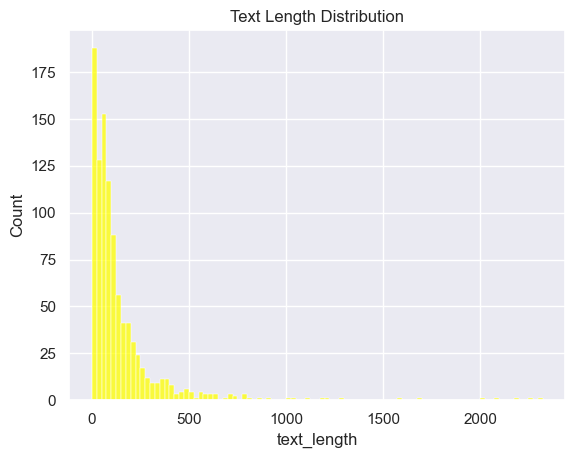

In [272]:
# Visualize a distribution of text_length
sns.histplot(data=df, x='text_length', bins='auto', color='yellow');
plt.title('Text Length Distribution')

Text(0, 0.5, 'Labels')

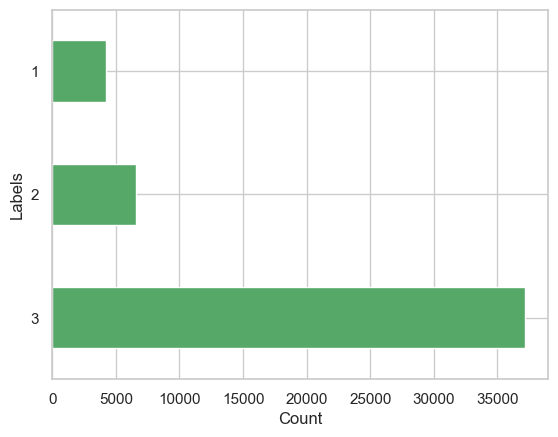

In [21]:
# Print the Distribution of Sentiment Labels
sns.set_theme(style="whitegrid")
ax = df['sentiment'].value_counts(sort=False).plot(kind='barh', color='g')
ax.set_xlabel('Count')
ax.set_ylabel('Labels')

Creating Train and Test set

In [199]:
X = df['review_body']
y = df['sentiment']

In [200]:
X, y = df.review_body.fillna(' '), df.sentiment

In [201]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size = 0.5, random_state=24)


Count Vectorizer

I will use a count vectorizer to vectorize the text data in the review column (training feature for this project) and then use three different classification models from scikit-learn models.

In [184]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [185]:
#Vectorizing the text data
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

LOGISTIC REGRESSION

In [173]:

from sklearn.linear_model import LogisticRegression

#Training the model
lr = LogisticRegression(multi_class ='multinomial',solver='lbfgs', max_iter=20000)
lr.fit(ctmTr, y_train)

#Accuracy score
lr_score = lr.score(X_test_dtm, y_test)
print("Results for Logistic Regression with CountVectorizer")
print(lr_score)

#Predicting the labels for test data
y_pred_lrc = lr.predict(X_test_dtm)


Results for Logistic Regression with CountVectorizer
0.8240489979584183


In [174]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_pred_lrc)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_pred_lrc)
print("Clasification Report: ")
print(result1)
result2 = accuracy_score(y_test,y_pred_lrc)
print("Accuracy:",result2)


Confusion Matrix: 
[[ 1035   480   564]
 [  536  1055  1716]
 [  206   721 17688]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.58      0.50      0.54      2079
           2       0.47      0.32      0.38      3307
           3       0.89      0.95      0.92     18615

    accuracy                           0.82     24001
   macro avg       0.65      0.59      0.61     24001
weighted avg       0.80      0.82      0.81     24001

Accuracy: 0.8240489979584183


SVM (Support Vector Machine)

In [186]:
from sklearn import svm
#Training the model
svcl = svm.SVC(kernel='rbf')
svcl.fit(ctmTr, y_train)
svcl_score = svcl.score(X_test_dtm, y_test)
print("Results for Support Vector Machine with CountVectorizer")
print(svcl_score)
y_pred_svc = svcl.predict(X_test_dtm)

Results for Support Vector Machine with CountVectorizer
0.8182992375317695


In [187]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_pred_svc)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_pred_svc)
print("Clasification Report: ")
print(result1)

result2 = accuracy_score(y_test,y_pred_svc)
print("Accuracy:",result2)


Confusion Matrix: 
[[  751   261  1067]
 [  273   493  2541]
 [   73   146 18396]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.68      0.36      0.47      2079
           2       0.55      0.15      0.23      3307
           3       0.84      0.99      0.91     18615

    accuracy                           0.82     24001
   macro avg       0.69      0.50      0.54     24001
weighted avg       0.78      0.82      0.78     24001

Accuracy: 0.8182992375317695


K-Nearest Neighbor

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(ctmTr, y_train)
knn_score = knn.score(X_test_dtm, y_test)
print("Results for KNN Classifier with CountVectorizer")
print(knn_score)
y_pred_knnc = knn.predict(X_test_dtm)


Results for KNN Classifier with CountVectorizer
0.7699679180034166


In [34]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_pred_knnc)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_pred_knnc)
print("Clasification Report: ")
print(result1)

result2 = accuracy_score(y_test,y_pred_knnc)
print("Accuracy:",result2)



Confusion Matrix: 
[[  510   317  1238]
 [  386   535  2366]
 [  362   852 17435]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.41      0.25      0.31      2065
           2       0.31      0.16      0.21      3287
           3       0.83      0.93      0.88     18649

    accuracy                           0.77     24001
   macro avg       0.52      0.45      0.47     24001
weighted avg       0.72      0.77      0.74     24001

Accuracy: 0.7699679180034166


TFIDF Vectorizer 

I will use the TF-IDF vectorizer. This vectorizer is known to be a more popular one because it uses the term frequency of the words. 

In [202]:

from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Logistic Regression

In [176]:

from sklearn.linear_model import LogisticRegression
lrt = LogisticRegression(multi_class='multinomial',solver='lbfgs', max_iter=20000)
lrt.fit(X_train_vec, y_train)
lr_score = lrt.score(X_test_vec, y_test)
print("Results for Logistic Regression with tfidf")
print(lr_score)
y_pred_lr = lrt.predict(X_test_vec)

Results for Logistic Regression with tfidf
0.8327986333902754


In [178]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_pred_lr)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_pred_lr)
print("Clasification Report: ")
print(result1)

result2 = accuracy_score(y_test,y_pred_lr)
print("Accuracy:",result2)


Confusion Matrix: 
[[  948   412   719]
 [  391   865  2051]
 [  104   336 18175]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.66      0.46      0.54      2079
           2       0.54      0.26      0.35      3307
           3       0.87      0.98      0.92     18615

    accuracy                           0.83     24001
   macro avg       0.69      0.56      0.60     24001
weighted avg       0.80      0.83      0.81     24001

Accuracy: 0.8327986333902754


SVM(Support Vector Machine)

In [182]:
from sklearn import svm

svcl = svm.SVC(kernel='rbf')
#clf_sv = GridSearchCV(svcl, params)
svcl.fit(X_train_vec, y_train)
svcl_score = svcl.score(X_test_vec, y_test)
print("Results for Support Vector Machine with tfidf")
print(svcl_score)
y_pred_sv = svcl.predict(X_test_vec)

Results for Support Vector Machine with tfidf
0.8288404649806258


In [183]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_pred_sv)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_pred_sv)
print("Clasification Report: ")
print(result1)

result2 = accuracy_score(y_test,y_pred_sv)
print("Accuracy:",result2)


Confusion Matrix: 
[[  900   343   836]
 [  348   657  2302]
 [   88   191 18336]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.67      0.43      0.53      2079
           2       0.55      0.20      0.29      3307
           3       0.85      0.99      0.91     18615

    accuracy                           0.83     24001
   macro avg       0.69      0.54      0.58     24001
weighted avg       0.80      0.83      0.80     24001

Accuracy: 0.8288404649806258


K-Nearest Neighbor

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_vec, y_train)
knn_score = knn.score(X_test_vec, y_test)
print("Results for KNN Classifier with tfidf")
print(knn_score)
y_pred_knn = knn.predict(X_test_vec)

Results for KNN Classifier with tfidf
0.7803424857297613


In [36]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_pred_knn)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_pred_knn)
print("Clasification Report: ")
print(result1)

result2 = accuracy_score(y_test,y_pred_knn)
print("Accuracy:",result2)


Confusion Matrix: 
[[  112    76  1877]
 [   82    77  3128]
 [   33    76 18540]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.49      0.05      0.10      2065
           2       0.34      0.02      0.04      3287
           3       0.79      0.99      0.88     18649

    accuracy                           0.78     24001
   macro avg       0.54      0.36      0.34     24001
weighted avg       0.70      0.78      0.70     24001

Accuracy: 0.7803424857297613


Random Forest Classifier

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
scores = cross_val_score(rf,X_train_vec,y_train.values.ravel(),cv=5)


In [204]:
print(scores)
scores.mean()

[0.77 0.78 0.77 0.76 0.77]


0.77

In [227]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [236]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,10,20,],
    'max_depth': [2,5,10,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train_vec,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 10}

0.768 (+/-0.008) for {'max_depth': 2, 'n_estimators': 5}
0.768 (+/-0.008) for {'max_depth': 2, 'n_estimators': 10}
0.768 (+/-0.008) for {'max_depth': 2, 'n_estimators': 20}
0.77 (+/-0.0) for {'max_depth': 5, 'n_estimators': 5}
0.768 (+/-0.008) for {'max_depth': 5, 'n_estimators': 10}
0.768 (+/-0.008) for {'max_depth': 5, 'n_estimators': 20}
0.77 (+/-0.0) for {'max_depth': 10, 'n_estimators': 5}
0.77 (+/-0.0) for {'max_depth': 10, 'n_estimators': 10}
0.77 (+/-0.013) for {'max_depth': 10, 'n_estimators': 20}
0.758 (+/-0.06) for {'max_depth': None, 'n_estimators': 5}
0.778 (+/-0.023) for {'max_depth': None, 'n_estimators': 10}
0.766 (+/-0.016) for {'max_depth': None, 'n_estimators': 20}


In [229]:
cv.best_estimator_

RandomForestClassifier(n_estimators=10)

In [237]:
rf3 = RandomForestClassifier(n_estimators=10)
rf3.fit(X_train_vec, y_train.values.ravel())
y_pred_rf = rf3.predict(X_test_vec)

In [238]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_pred_rf)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_pred_rf)
print("Clasification Report: ")
print(result1)

result2 = accuracy_score(y_test,y_pred_rf)
print("Accuracy:",result2)


Confusion Matrix: 
[[  3   6  43]
 [  4   8  79]
 [  5   4 348]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.25      0.06      0.09        52
           2       0.44      0.09      0.15        91
           3       0.74      0.97      0.84       357

    accuracy                           0.72       500
   macro avg       0.48      0.37      0.36       500
weighted avg       0.64      0.72      0.64       500

Accuracy: 0.718


Naive Bayes

In [159]:

from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf vectorizer
vectorizer = TfidfVectorizer()

In [160]:
sentiment_classifier = Pipeline(steps=[
                               ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('naive_bayes',MultinomialNB())
                                 ])

In [161]:
# train the sentiment classifier 
sentiment_classifier.fit(X_train,y_train)
# test model performance on valid data 
y_preds_nb = sentiment_classifier.predict(X_test)

In [162]:
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
result = confusion_matrix(y_test,y_preds_nb)
print("Confusion Matrix: ")
print(result)

result1 = classification_report(y_test,y_preds_nb)
print("Clasification Report: ")
print(result1)

result2 = accuracy_score(y_test,y_preds_nb)
print("Accuracy:",result2)

Confusion Matrix: 
[[   23     2  2054]
 [    1     1  3305]
 [    0     1 18614]]
Clasification Report: 
              precision    recall  f1-score   support

           1       0.96      0.01      0.02      2079
           2       0.25      0.00      0.00      3307
           3       0.78      1.00      0.87     18615

    accuracy                           0.78     24001
   macro avg       0.66      0.34      0.30     24001
weighted avg       0.72      0.78      0.68     24001

Accuracy: 0.7765509770426232
